In [1]:
! nvidia-smi

Thu Nov  3 21:57:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from datasets import load_dataset
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import AutoConfig
from functools import partial
import torch
import torch.nn.functional as F
import random
import numpy as np
from tqdm.autonotebook import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import LambdaLR
from torch import nn
from collections import defaultdict, OrderedDict
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from matplotlib import pyplot as plt

In [5]:
MODEL_NAME = 'xlm-roberta-base'

epochs = 3
# epochs_lr = 10

epoch_lr = 50
batch_size = 8
lr = 2e-5

weight_decay = 0.01
warmup_steps = 200

input_dim = 768
hidden_dim = 128
output_dim = 2

In [6]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

enforce_reproducibility()

In [7]:
""" Official evaluation script for v1.1 of the SQuAD dataset. """
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


def evaluate_squad(dataset, predictions):
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    message = 'Unanswered question ' + qa['id'] + \
                              ' will receive score 0.'
                    print(message, file=sys.stderr)
                    continue
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                prediction = predictions[qa['id']]
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}

def compute_squad(predictions, references):
  pred_dict = {prediction["id"]: prediction["prediction_text"] for prediction in predictions}
  dataset = [
      {
          "paragraphs": [
              {
                  "qas": [
                      {
                          "answers": [{"text": answer_text} for answer_text in ref["answers"]["text"]],
                          "id": ref["id"],
                      }
                      for ref in references
                  ]
              }
          ]
      }
  ]
  score = evaluate_squad(dataset=dataset, predictions=pred_dict)
  return score

In [8]:
# this is also equivalent to those 2 lines. I recommend going with that, unless you want more control over your code
from datasets import load_metric
compute_squad = load_metric("squad_v2")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
tk = AutoTokenizer.from_pretrained(MODEL_NAME)

In [10]:
def get_train_features(tk, samples):
    '''
    Tokenizes all of the text in the given samples, splittling inputs that are too long for our model
    across multiple features. Finds the token offsets of the answers, which serve as the labels for
    our inputs.
    '''
    batch = tk.batch_encode_plus(
        [[q, c] for q, c in zip(samples['question_text'], samples['document_plaintext'])],
        padding='max_length',
        truncation='only_second',
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

    # Get a list which maps the input features index to their original index in the
    # samples list (for split inputs). E.g. if our batch size is 4 and the second sample
    # is split into 3 inputs because it is very large, sample_mapping would look like
    # [0, 1, 1, 1, 2, 3]
    sample_mapping = batch.pop('overflow_to_sample_mapping')
    # Get all of the character offsets for each token
    offset_mapping = batch.pop('offset_mapping')

    # Store the start and end tokens
    batch['start_tokens'] = []
    batch['end_tokens'] = []
    batch['no_answer_probability'] = []

    # Iterate through all of the offsets
    for i, offsets in enumerate(offset_mapping):
        # Get the right sample by mapping it to its original index
        sample_idx = sample_mapping[i]
        # Get the sequence IDs to know where context starts so we can ignore question tokens
        sequence_ids = batch.sequence_ids(i)

        # Get the start and end character positions of the answer
        ans = samples['annotations'][sample_idx]
        start_char = ans['answer_start'][0]
        end_char = start_char + len(ans['answer_text'][0])
        # while end_char > 0 and (end_char >= len(samples['context'][sample_idx]) or samples['context'][sample_idx][end_char] == ' '):
        #   end_char -= 1

        # Start from the first token in the context, which can be found by going to the
        # first token where sequence_ids is 1
        start_token = 0
        no_answer_probability = 0
        while sequence_ids[start_token] != 1:
            start_token += 1

        end_token = len(offsets) - 1
        while sequence_ids[end_token] != 1:
            end_token -= 1

        # By default set it to the CLS token if the answer isn't in this input
        if start_char < offsets[start_token][0] or end_char > offsets[end_token][1]:
            start_token = 0
            end_token = 0
        # Otherwise find the correct token indices
        else:
            # Advance the start token index until we have passed the start character index
            while start_token < len(offsets) and offsets[start_token][0] <= start_char:
                start_token += 1
            start_token -= 1

            # Decrease the end token index until we have passed the end character index
            while end_token >= 0 and offsets[end_token][1] >= end_char:
                end_token -= 1
            end_token += 1
        
        # no answer probability
        if ans['answer_start'] == [-1]:
            no_answer_probability = 1
        else:
            no_answer_probability = 0


        batch['start_tokens'].append(start_token)
        batch['end_tokens'].append(end_token)
        batch['no_answer_probability'].append(no_answer_probability)

    # batch['start_tokens'] = np.array(batch['start_tokens'])
    # batch['end_tokens'] = np.array(batch['end_tokens'])

    return batch

def collate_fn(inputs):
    '''
    Defines how to combine different samples in a batch
    '''
    input_ids = torch.tensor([i['input_ids'] for i in inputs])
    attention_mask = torch.tensor([i['attention_mask'] for i in inputs])
    start_tokens = torch.tensor([i['start_tokens'] for i in inputs])
    end_tokens = torch.tensor([i['end_tokens'] for i in inputs])
    no_answer_probability = torch.tensor([i['no_answer_probability'] for i in inputs])

    # Truncate to max length
    max_len = max(attention_mask.sum(-1))
    input_ids = input_ids[:, :max_len]
    attention_mask = attention_mask[:, :max_len]

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'start_tokens': start_tokens,
            'end_tokens': end_tokens, 'no_answer_probability': no_answer_probability}

In [11]:
def get_validation_features(tk, samples):
    # First, tokenize the text. We get the offsets and return overflowing sequences in
    # order to break up long sequences into multiple inputs. The offsets will help us
    # determine the original answer text
    batch = tk.batch_encode_plus(
        [[q, c] for q, c in zip(samples['question_text'], samples['document_plaintext'])],
        padding='max_length',
        truncation='only_second',
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

    # We'll store the ID of the samples to calculate squad score
    batch['example_id'] = []

    batch['no_answer_probability'] = []

    # The overflow sample map tells us which input each sample corresponds to
    sample_map = batch.pop('overflow_to_sample_mapping')

    for i in range(len(batch['input_ids'])):
        # The sample index tells us which of the values in "samples" these features belong to
        sample_idx = sample_map[i]
        sequence_ids = batch.sequence_ids(i)

        # Add the ID to map these features back to the correct sample
        batch['example_id'].append(samples['id'][sample_idx])

        # Set offsets for non-context words to be None for ease of processing
        batch['offset_mapping'][i] = [o if sequence_ids[k] == 1 else None for k, o in
                                      enumerate(batch['offset_mapping'][i])]

        # no answer probability
        ans = samples['annotations'][sample_idx]
        if ans['answer_start'] == [-1]:
            no_answer_probability = 1
        else:
            no_answer_probability = 0

        batch['no_answer_probability'].append(no_answer_probability)

    return batch

def val_collate_fn(inputs):
    input_ids = torch.tensor([i['input_ids'] for i in inputs])
    attention_mask = torch.tensor([i['attention_mask'] for i in inputs])
    no_answer_probability = torch.tensor([i['no_answer_probability'] for i in inputs])


    # Truncate to max length
    max_len = max(attention_mask.sum(-1))
    input_ids = input_ids[:, :max_len]
    attention_mask = attention_mask[:, :max_len]

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'no_answer_probability': no_answer_probability}

In [12]:
def predict(model: nn.Module, valid_dl: DataLoader):
    """
    Evaluates the model on the given dataset
    :param model: The model under evaluation
    :param valid_dl: A `DataLoader` reading validation data
    :return: The accuracy of the model on the dataset
    """
    # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
    # layer normalization and dropout
    model.eval()
    start_logits_all = []
    end_logits_all = []
    no_answer_probability_logits_all = []

    # ALSO IMPORTANT: Don't accumulate gradients during this process
    with torch.no_grad():
        for batch in tqdm(valid_dl, desc='Evaluation'):
            batch = {b: batch[b].to('cuda') for b in batch}

            # Pass the inputs through the model, get the current loss and logits
            transformer_out, classify_labels = model.validate(batch)
            # Store the "start" class logits and "end" class logits for every token in the input
            start_logits_all.extend(list(transformer_out['start_logits'].detach().cpu().numpy()))
            end_logits_all.extend(list(transformer_out['end_logits'].detach().cpu().numpy()))
            no_answer_probability_logits_all.extend(list(F.sigmoid(classify_labels[:,1]).detach().cpu().numpy()))            

        return start_logits_all, end_logits_all, no_answer_probability_logits_all

def post_process_predictions(examples, dataset, logits, num_possible_answers=20, max_answer_length=30):
    all_start_logits, all_end_logits, all_no_answer_probability_logits = logits
    
    # Build a map from example to its corresponding features. This will allow us to index from
    # sample ID to all of the features for that sample (in case they were split up due to long input)
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = defaultdict(list)
    for i, feature in enumerate(dataset):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # Create somewhere to store our predictions
    predictions = OrderedDict()

    # Iterate through each sample in the dataset
    for j, sample in enumerate(tqdm(examples)):

        # Get the feature indices (all of the features split across the batch)
        feature_indices = features_per_example[j]
        # Get the original context which predumably has the answer text
        context = sample['document_plaintext']

        preds = []
        # Iterate through all of the features
        for ft_idx in feature_indices:

            # Get the start and end answer logits for this input
            start_logits = all_start_logits[ft_idx]
            end_logits = all_end_logits[ft_idx]
            no_answer_probability_logits = all_no_answer_probability_logits[ft_idx]

            # Get the offsets to map token indices to character indices
            offset_mapping = dataset[ft_idx]['offset_mapping']

            # Sort the logits and take the top N
            start_indices = np.argsort(start_logits)[::-1][:num_possible_answers]
            end_indices = np.argsort(end_logits)[::-1][:num_possible_answers]

            # Iterate through start and end indices
            for start_index in start_indices:
                for end_index in end_indices:

                    # Ignore this combination if either the indices are not in the context
                    if start_index >= len(offset_mapping) or end_index >= len(offset_mapping) or offset_mapping[
                        start_index] is None or offset_mapping[end_index] is None:
                        continue

                    # Also ignore if the start index is greater than the end index of the number of tokens
                    # is greater than some specified threshold
                    if start_index > end_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    ans_text = context[offset_mapping[start_index][0]:offset_mapping[end_index][1]]
                    preds.append({
                        'score': start_logits[start_index] + end_logits[end_index],
                        'text': ans_text
                    })

        if len(preds) > 0:
            # Sort by score to get the top answer
            answer = sorted(preds, key=lambda x: x['score'], reverse=True)[0]
        else:
            answer = {'score': 0.0, 'text': ""}

        predictions[sample['id']] = [answer['text'], no_answer_probability_logits]
    return predictions

In [13]:
def getLanguageDataSet(data, language):
    def printAndL(x):
        return x["language"] in language

    return data.filter(printAndL)

In [14]:
def process_train_data(language):
    dataset = load_dataset("copenlu/answerable_tydiqa")
    dataset = getLanguageDataSet(dataset, language)['train']
    dataset = dataset.remove_columns("language")
    dataset = dataset.remove_columns("document_url")

    tokenized_dataset = dataset.map(partial(get_train_features, tk), batched=True, remove_columns=dataset.column_names)
    return tokenized_dataset

def process_validation_data(language):
    dataset = load_dataset("copenlu/answerable_tydiqa")
    dataset = getLanguageDataSet(dataset, language)['validation']
    dataset = dataset.remove_columns("language")
    dataset = dataset.remove_columns("document_url")
    ids = [i for i in range(len(dataset['question_text']))]
    dataset = dataset.add_column('id',ids)

    tokenized_dataset = dataset.map(partial(get_validation_features, tk), batched=True, remove_columns=dataset.column_names)
    return tokenized_dataset

In [15]:
class new_model(nn.Module):
    def __init__(self,hidden_dim,output_dim):
        super(new_model,self).__init__()
        self.transformer_layer = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME).to(device)
        self.classify_layer = nn.Linear(hidden_dim,output_dim)
        # self.qa_outputs = nn.Linear(hidden_dim, output_dim)

    def mean_pooling(self,model_output, attention_mask):
        # Mean Pooling - Take attention mask into account for correct averaging
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.size()).float()
        sum_embeddings = torch.sum(model_output * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self,input):
        transformer_out = self.transformer_layer(
                input_ids=input['input_ids'],
                attention_mask=input['attention_mask'],
                start_positions=input['start_tokens'],
                end_positions=input['end_tokens'],
                output_hidden_states=True,
                return_dict=True
        )
        hiddent_states = transformer_out['hidden_states']
        hidden_out = self.mean_pooling(hiddent_states[-1],input['attention_mask'])
        classify_labels = self.classify_layer(hidden_out)

        return transformer_out, classify_labels

    def validate(self,input):
        transformer_out = self.transformer_layer(
                input_ids=input['input_ids'],
                attention_mask=input['attention_mask'],
                output_hidden_states=True,
                return_dict=True
        )
        hiddent_states = transformer_out['hidden_states']
        hidden_out = self.mean_pooling(hiddent_states[-1],input['attention_mask'])
        classify_labels = self.classify_layer(hidden_out)

        return transformer_out, classify_labels

In [16]:
def train(
        model: nn.Module,
        train_dl: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: LambdaLR,
        n_epochs: int,
        device: torch.device
):
    """
    The main training loop which will optimize a given model on a given dataset
    :param model: The model being optimized
    :param train_dl: The training dataset
    :param optimizer: The optimizer used to update the model parameters
    :param n_epochs: Number of epochs to train for
    :param device: The device to train on
    """

    # Keep track of the loss and best accuracy
    losses = []
    best_acc = 0.0
    pcounter = 0

    # Iterate through epochs
    for ep in range(n_epochs):

        loss_epoch = []

        # Iterate through each batch in the dataloader
        for batch in tqdm(train_dl):
            # VERY IMPORTANT: Make sure the model is in training mode, which turns on
            # things like dropout and layer normalization
            model.train()

            # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
            # keeps track of these dynamically in its computation graph so you need to explicitly
            # zero them out
            optimizer.zero_grad()

            # Place each tensor on the GPU
            batch = {b: batch[b].to(device) for b in batch}

            # Pass the inputs through the model, get the current loss and logits
            transformer_out, classify_labels = model(batch)

            true_classify_labels = batch['no_answer_probability']
            loss = 0.5* transformer_out['loss'] +  0.5 * criterion(classify_labels,true_classify_labels)
            # loss = transformer_out['loss']
            losses.append(loss.item())
            loss_epoch.append(loss.item())

            # Calculate all of the gradients and weight updates for the model
            loss.backward()

            # Optional: clip gradients
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Finally, update the weights of the model and advance the LR schedule
            optimizer.step()
            scheduler.step()
            # gc.collect()
    return losses

In [17]:
tokenized_train_dataset = process_train_data(["english"])
train_dl = DataLoader(tokenized_train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=batch_size)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/117 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [18]:
model = new_model(hidden_dim=768,output_dim=2).to(device)

model

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream tas

new_model(
  (transformer_layer): XLMRobertaForQuestionAnswering(
    (roberta): XLMRobertaModel(
      (embeddings): XLMRobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): XLMRobertaEncoder(
        (layer): ModuleList(
          (0): XLMRobertaLayer(
            (attention): XLMRobertaAttention(
              (self): XLMRobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): XLMRobertaSelfOutput(
     

In [19]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps,
    epochs * len(train_dl)
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
criterion = torch.nn.CrossEntropyLoss()

In [21]:
losses = train(
    model,
    train_dl,
    optimizer,
    scheduler,
    epochs,
    device
)

  0%|          | 0/939 [00:00<?, ?it/s]

  0%|          | 0/939 [00:00<?, ?it/s]

  0%|          | 0/939 [00:00<?, ?it/s]

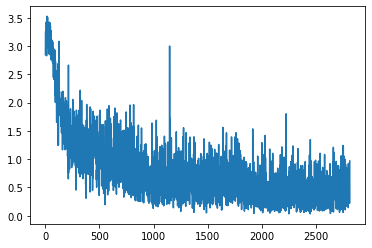

In [22]:
plt.cla()
plt.plot(losses)


In [23]:
tokenized_val_dataset = process_validation_data(["english"])
example_val = load_dataset("copenlu/answerable_tydiqa")
example_val = getLanguageDataSet(example_val, ["english"])['validation']

ids = [i for i in range(len(example_val['question_text']))]
example_val = example_val.add_column('id',ids)


  0%|          | 0/2 [00:00<?, ?it/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

In [24]:
val_dl = DataLoader(tokenized_val_dataset, collate_fn=val_collate_fn, shuffle=False, batch_size=batch_size)
logits = predict(model, val_dl)


Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [25]:
id_list = []
answer_list = []

for example in example_val:
    id_list.append(example['id'])
    answer_list.append(example['annotations'])

for mydict in answer_list:
    mydict['text'] = mydict.pop('answer_text')

print(id_list[:10])
print(answer_list[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[{'answer_start': [51], 'text': ['cleaning and protection from reinjury or infection']}, {'answer_start': [0], 'text': ['Brothers Amos and Wilfrid Ayre']}, {'answer_start': [295], 'text': ['2.3–2.8mm']}, {'answer_start': [352], 'text': ['December 1988']}, {'answer_start': [32], 'text': ['1939']}, {'answer_start': [48], 'text': ['1912']}, {'answer_start': [109], 'text': ['2 billion']}, {'answer_start': [59], 'text': ['923']}, {'answer_start': [253], 'text': ['9 September 1923']}, {'answer_start': [208], 'text': ['6 June 1944']}]


In [26]:
predictions = post_process_predictions(example_val, tokenized_val_dataset, logits)
formatted_predictions = [{'id': k, 'prediction_text': v[0], 'no_answer_probability': v[1]} for k, v in predictions.items()]
gold = [{'id': id_list[i], 'answers': answer_list[i]} for i in range(len(id_list))]

  0%|          | 0/990 [00:00<?, ?it/s]

In [27]:
formatted_predictions[:10]

[{'id': 0,
  'prediction_text': 'cleaning and protection from reinjury or infection',
  'no_answer_probability': 0.42501578},
 {'id': 1,
  'prediction_text': 'Brothers Amos and Wilfrid Ayre',
  'no_answer_probability': 0.13801982},
 {'id': 2, 'prediction_text': '2.3–2.8mm', 'no_answer_probability': 0.8308496},
 {'id': 3,
  'prediction_text': '31 March 1989',
  'no_answer_probability': 0.75676197},
 {'id': 4, 'prediction_text': '1939', 'no_answer_probability': 0.35512874},
 {'id': 5, 'prediction_text': '1912', 'no_answer_probability': 0.082175136},
 {'id': 6,
  'prediction_text': 'roughly 2 billion',
  'no_answer_probability': 0.10151244},
 {'id': 7, 'prediction_text': '923', 'no_answer_probability': 0.4798822},
 {'id': 8, 'prediction_text': '1919', 'no_answer_probability': 0.09148321},
 {'id': 9,
  'prediction_text': '6 June 1944',
  'no_answer_probability': 0.07828882}]

In [28]:
gold[:10]

[{'id': 0,
  'answers': {'answer_start': [51],
   'text': ['cleaning and protection from reinjury or infection']}},
 {'id': 1,
  'answers': {'answer_start': [0],
   'text': ['Brothers Amos and Wilfrid Ayre']}},
 {'id': 2, 'answers': {'answer_start': [295], 'text': ['2.3–2.8mm']}},
 {'id': 3, 'answers': {'answer_start': [352], 'text': ['December 1988']}},
 {'id': 4, 'answers': {'answer_start': [32], 'text': ['1939']}},
 {'id': 5, 'answers': {'answer_start': [48], 'text': ['1912']}},
 {'id': 6, 'answers': {'answer_start': [109], 'text': ['2 billion']}},
 {'id': 7, 'answers': {'answer_start': [59], 'text': ['923']}},
 {'id': 8, 'answers': {'answer_start': [253], 'text': ['9 September 1923']}},
 {'id': 9, 'answers': {'answer_start': [208], 'text': ['6 June 1944']}}]

In [29]:
compute_squad.compute(references=gold, predictions=formatted_predictions)


{'exact': 26.96969696969697,
 'f1': 33.213017916536735,
 'total': 990,
 'HasAns_exact': 26.96969696969697,
 'HasAns_f1': 33.213017916536735,
 'HasAns_total': 990,
 'best_exact': 26.96969696969697,
 'best_exact_thresh': 0.8492646217346191,
 'best_f1': 33.21301791653673,
 'best_f1_thresh': 0.8492646217346191}